# AI-assisted Enzyme Design
### Design enzymes evaluate the stability and reliability of protein sequences. We hope to identify the best de novo designed ADH with catlaytic function towards ethanol.
```
conda acivate class2
pip install biopython
conda install clustalo
```
## The exercise today is mainly about how to evaluate the Stability and Reliability of the protein sequences you have generated by using previous exercise methods and docking, which include:

### 1.  EC number
### 2.  Enzyme-substrate pairs
### 3.  Enzyme-Substrate Activity Parameter(Kcat/Km)
### 4.  Docking

## Attention
### This Exercise need the fasta you have generated in Exercise 5, and rename as **generated_sequences.fasta**, then you can go forward.

## 6.1 EC number
## Protein Function Prediction Workflow (EC Classification). We need to make sure the generated sequences are belong to ADH, which has the EC number 1.1.1.1 Those which arenot will be filtered.

### 1. Functional Prediction
- **Objective**: Predict the EC (Enzyme Commission) number from a given protein sequence.
- **Tools**: 
  - `CLEAN`

---

### 2. EC Validation
- **Purpose**: Validate the predicted EC number.
- **Steps**:
  - Check if the predicted EC number matches the target enzyme function **1.1.1.1**.
  - If a match occurs, We consider that the generated protein sequences have **high functional reliability**.

---

### 3. MSA and Sequence Comparison
- **Goal**: Analyze the alignment of generated sequences.
- **Steps**:
  1. Perform **Multiple Sequence Alignment (MSA)** on the generated sequences.
  2. Compare the sequence alignment information between sequences predicted as **EC 1.1.1.1** and those with other EC numbers.
  3. Visualize differences using:
      - **Evolutionary Trees** 



In [1]:
# import CLEAN and set file path
import sys
import warnings
import csv

warnings.filterwarnings("ignore")
sys.path.append("/data/home/wuke/Project/Course-AI-EnzymeDesign/Exercise4/CLEAN/src")
from CLEAN.infer import *
target_protein_fasta_file = 'generated_sequences.fasta'
file_name = target_protein_fasta_file.split('/')[-1].split('.')[0]
# print(file_name)
target_protein_csv_file = 'ec_predict/data/' + file_name + '.csv'
target_protein_result_file = 'ec_predict/results/'+ file_name +'_maxsep.csv'
clean_result_file = 'ec_predict/results/'+ file_name +'_clean_result.json'

In [2]:
# Function that convert your fasta to csv needed for testing
def fasta_to_csv(fasta_name, csv_name):
    with open(fasta_name, 'r') as fastafile, open(csv_name, 'w') as outfile:
        csv_rows = []
        fasta_id = ''
        for line in fastafile:
            line = line.strip()
            if line.startswith('>'):
                if fasta_id:
                    csv_rows.append([fasta_id, fasta_sequence])
                fasta_id = line[1:]
                fasta_sequence = ''
            else:
                fasta_sequence += line
        if fasta_id:
            csv_rows.append([fasta_id, fasta_sequence])
        header = ['Entry', 'Sequence']
        csv_rows.insert(0, header)
        csvwriter = csv.writer(outfile, delimiter='\t')
        csvwriter.writerows(csv_rows)

fasta_to_csv(target_protein_fasta_file, target_protein_csv_file)

In [3]:
## EC_number prediction workflow
from CLEAN.infer import *
## We use esm to generate embeddings for EC_number prediction
## The embedding files save in Exercise6/ec_predict/data/esm_data
retrive_esm1b_embedding(file_name)

## Prediction by loading the pretrained-model(CLEAN)
## The results save at Exercise6/ec_predict/results
## The parameter "split100" denotes the train dataset name
infer_maxsep("split100", file_name, report_metrics=True, pretrained=True)

Transferred model to GPU
Read generated_sequences.fasta with 13 sequences
Processing 1 of 2 batches (10 sequences)
Processing 2 of 2 batches (3 sequences)
The embedding sizes for train and test: torch.Size([241025, 128]) torch.Size([13, 128])


100%|██████████| 5242/5242 [00:00<00:00, 24875.76it/s]


Calculating eval distance map, between 13 test ids and 5242 train EC cluster centers


13it [00:00, 236.16it/s]


Result save in: ec_predict/results/generated_sequences


In [4]:
## Check the result
import pandas as pd
ec_result = pd.read_csv('ec_predict/results/generated_sequences_maxsep.csv', header=None, names=["Sample", "EC1", "EC2", "EC3"])
ec_result.fillna('', inplace=True)
ec_result

,Sample,EC1,EC2,EC3
0,Sample_0_0,EC:1.1.1.1/4.6420,,
1,Sample_0_1,EC:1.1.1.105/5.6071,EC:1.1.1.1/5.7403,EC:1.1.1.66/5.9653
2,Sample_1_0,EC:1.3.1.104/7.6191,EC:1.1.1.362/7.6840,
3,Sample_1_1,EC:1.1.1.1/6.1834,,
4,Sample_2_0,EC:1.1.1.1/3.2675,EC:1.1.1.284/3.6406,
5,Sample_2_1,EC:1.1.1.1/3.4841,,
6,Sample_3_0,EC:1.1.1.1/4.5913,EC:1.1.1.105/4.7924,
7,Sample_3_1,EC:1.1.1.1/4.2953,,
8,Sample_4_0,EC:1.1.1.284/2.6334,,
9,Sample_4_1,EC:1.1.1.284/2.4425,,


#### The above results represent the predicted EC numbers. However, some proteins have multiple EC numbers, which indicates that these EC numbers performed well in multiple categories during the classification task. Next, we will use a JSON format to better present these results.

In [5]:
import pandas as pd
import json

def get_clean_predict_result(target_protein_result_file,clean_result_file):
    data = []
    max_columns = 0
    with open(target_protein_result_file, 'r', encoding='utf-8') as file:
        reader = csv.reader(file)
        for row in reader:
            max_columns = max(max_columns, len(row))
            data.append(row)
    for row in data:
        row.extend([''] * (max_columns - len(row)))

    tmp_res = pd.DataFrame(data)
    for i in range(1,max_columns):
        tmp_res[i] = tmp_res[i].apply(lambda x:x.split('/')[0].split(':')[1] if '/' in x else x)
    tmp_res

    clean_result = {}
    for index,row in tmp_res.iterrows():
        ec_list = []
        for i in range(1,max_columns):
            ec_list.append(row[i])
        clean_result[row[0]] = [x for x in ec_list if x != '']
        
    with open(clean_result_file, 'w') as json_file:
        json.dump(clean_result, json_file) 

In [6]:
get_clean_predict_result(target_protein_result_file,clean_result_file)

In [7]:
# Use Json format to better show the result
with open(clean_result_file, 'r', encoding='utf-8') as file:
    data = json.load(file)  

print("result of JSON format：")
print(json.dumps(data, separators=(",", ":"), ensure_ascii=False))

result of JSON format：
{"Sample_0_0":["1.1.1.1"],"Sample_0_1":["1.1.1.105","1.1.1.1","1.1.1.66"],"Sample_1_0":["1.3.1.104","1.1.1.362"],"Sample_1_1":["1.1.1.1"],"Sample_2_0":["1.1.1.1","1.1.1.284"],"Sample_2_1":["1.1.1.1"],"Sample_3_0":["1.1.1.1","1.1.1.105"],"Sample_3_1":["1.1.1.1"],"Sample_4_0":["1.1.1.284"],"Sample_4_1":["1.1.1.284"],"Sample_5_0":["1.1.1.284"],"Sample_5_1":["1.1.1.284"],"natural_sequence":["1.1.1.284"]}


## Question 1: How many sequences are annotated with the EC number 1.1.1.1


————————————————————————————————————————————————

### Next, we will filter out sequences that do not belong to the EC number 1.1.1.1.

In [8]:
import json
from Bio import SeqIO 
#  To filter the JSON data and keep only entries that contain EC 1.1.1.1
filtered_sequence = {key: value for key, value in data.items() if "1.1.1.1" in value}
print(filtered_sequence)

input_fasta = "generated_sequences.fasta"  
output_fasta = "filtered_sequences_ec.fasta"  

# Parse the FASTA file and filter the target sequences.
with open(output_fasta, 'w') as output_handle:
    for record in SeqIO.parse(input_fasta, "fasta"):
        # If the sequence ID is in the target list, save it to a new file
        if record.id in filtered_sequence:
            SeqIO.write(record, output_handle, "fasta")

print(f"Filtered sequences saved to {output_fasta}")

{'Sample_0_0': ['1.1.1.1'], 'Sample_0_1': ['1.1.1.105', '1.1.1.1', '1.1.1.66'], 'Sample_1_1': ['1.1.1.1'], 'Sample_2_0': ['1.1.1.1', '1.1.1.284'], 'Sample_2_1': ['1.1.1.1'], 'Sample_3_0': ['1.1.1.1', '1.1.1.105'], 'Sample_3_1': ['1.1.1.1']}
Filtered sequences saved to filtered_sequences_ec.fasta


## Question 2: Could you search for one natural ADH sequence whose EC number is 1.1.1.1 from [Uniprot](https://www.uniprot.org/)
### Please paste the protein sequence below and we will use it in following parts

EXAMPLE: Natural sequence : MANEVIKCKAAVAWEAGKPLSIEEIEVAPPKAHEVRIKIIATAVCHTDAYTLSGADPEGCFPVILGHEGAGIVESVGEGVTKLKAGDTVIPLYIPQCGECKFCLNPKTNLCQKIRVTQGKGLMPDGTSRFTCKGKTILHYMGTSTFSEYTVVADISVAKIDPLAPLDKVCLLGCGISTGYGAAVNTAKLEPGSVCAVFGLGGVGLAVIMGCKVAGASRIIGVDINKDKFARAKEFGATECINPQDFSKPIQEVLIEMTDGGVDYSFECIGNVKVMRAALEACHKGWGVSVVVGVAASGEEIATRPFQLVTGRTWKGTAFGGWKSVESVPKLVSEYMSKKIKVDEFVTHNLSFDEINKAFELMHSGKSIRTVVKI

### Next section we will use MSA(Multiple sequence alignment) to evaluate the similarity and identity of generated sequences and the natural ADH sequence, 
### You can click the link to access more information about [MSA](https://en.wikipedia.org/wiki/Multiple_sequence_alignment) 

In [9]:
# Add the natural ADH sequence into generated_sequences.fasta in order to next step
# type the sequence you have searched
target_protein_fasta_file = "filtered_sequences_ec.fasta"
natural_sequence = 'MANEVIKCKAAVAWEAGKPLSIEEIEVAPPKAHEVRIKIIATAVCHTDAYTLSGADPEGCFPVILGHEGAGIVESVGEGVTKLKAGDTVIPLYIPQCGECKFCLNPKTNLCQKIRVTQGKGLMPDGTSRFTCKGKTILHYMGTSTFSEYTVVADISVAKIDPLAPLDKVCLLGCGISTGYGAAVNTAKLEPGSVCAVFGLGGVGLAVIMGCKVAGASRIIGVDINKDKFARAKEFGATECINPQDFSKPIQEVLIEMTDGGVDYSFECIGNVKVMRAALEACHKGWGVSVVVGVAASGEEIATRPFQLVTGRTWKGTAFGGWKSVESVPKLVSEYMSKKIKVDEFVTHNLSFDEINKAFELMHSGKSIRTVVKI'
natural_sequence_id = ">natural_sequence"

with open(target_protein_fasta_file, "a") as file:
    file.write(f"\n{natural_sequence_id}\n{natural_sequence}\n")

In [10]:
# MSA sequence alignment analysis

from Bio.Align.Applications import ClustalOmegaCommandline
from Bio import AlignIO

# Clustal Omega for multiple sequence alignment
clustalomega_cline = ClustalOmegaCommandline(infile="filtered_sequences_ec.fasta", outfile="aligned_sequences.aln", outfmt="clu")
clustalomega_cline()

# multiple sequence alignment result
alignment = AlignIO.read("aligned_sequences.aln", "clustal")
print(alignment)

Alignment with 8 rows and 461 columns
MSTAGKPIKCKAAVCWEAQKPLVIEEVEVDPPKAHEVRIKIKAT...--- Sample_0_0
MATAGKPITCKAAVCRKLGEPLVIEEVQVAPPKAHEVRIKMVCT...--- Sample_0_1
--------------------------------------------...GKK Sample_1_1
MATAGKVITCKAAVAWEAGKPLVIEEVEVAPPKAHEVRLKIKFT...--- Sample_2_0
MATAGQVIKCKAAVAWEAGKPLVIEEVEVAPPKAHEVRLKIVCT...--- Sample_2_1
MSTSGKPIKCKAAVLWEAKKPLVIEEVEVAPPKAHEVRIKVVAT...--- Sample_3_0
MATAGKVIKCKAAVLHEPGKPMTIEEVEVAPPKAHEVRIKIVAT...--- Sample_3_1
--MANEVIKCKAAVAWEAGKPLSIEEIEVAPPKAHEVRIKIIAT...--- natural_sequence


### In Multiple Sequence Alignment (MSA), identity and similarity are two key metrics that measure the degree of match between sequences. 
### Identity refers to the proportion of identical residues (amino acids or nucleotides) at the same positions in the aligned sequences. 
### Similarity, on the other hand, is the proportion of residues that are either identical or similar in the aligned sequences. 

In [11]:
# Analyze the alignment results about sequence similarity and indentity.
from Bio import AlignIO

alignment = AlignIO.read("aligned_sequences.aln", "clustal")
num_columns = alignment.get_alignment_length()
num_sequences = len(alignment)

identical_positions = 0
similar_positions = 0

for i in range(num_columns):
    column = alignment[:, i]
    if column.count(column[0]) == num_sequences:  # All identical
        identical_positions += 1
    elif "-" not in column:  # Exclude gaps, consider similar residues
        similar_positions += 1

print("Total Columns:", num_columns)
print("Identical Positions:", identical_positions)
print("Similarity Score:", similar_positions / num_columns)
print("Identity Score:", identical_positions / num_columns)


Total Columns: 461
Identical Positions: 11
Similarity Score: 0.3492407809110629
Identity Score: 0.02386117136659436


### Sequence distance matrix is a matrix that represents the similarity between a set of sequences. In bioinformatics, it is commonly used to display the degree of difference between various DNA, RNA, or protein sequences

In [12]:
# sequence distance matrix
from Bio import AlignIO
from Bio.Phylo.TreeConstruction import DistanceCalculator

alignment = AlignIO.read("aligned_sequences.aln", "clustal")
calculator = DistanceCalculator("identity")  # use identity model
dm = calculator.get_distance(alignment)
print(dm)  # print the distance matrix


Sample_0_0  0.000000
Sample_0_1  0.288503    0.000000
Sample_1_1  0.930586    0.926247    0.000000
Sample_2_0  0.347072    0.390456    0.934924    0.000000
Sample_2_1  0.347072    0.381779    0.926247    0.132321    0.000000
Sample_3_0  0.247289    0.297180    0.930586    0.336226    0.340564    0.000000
Sample_3_1  0.266811    0.288503    0.913232    0.360087    0.351410    0.266811    0.000000
natural_sequence    0.288503    0.342733    0.924078    0.388286    0.390456    0.305857    0.308026    0.000000
    Sample_0_0  Sample_0_1  Sample_1_1  Sample_2_0  Sample_2_1  Sample_3_0  Sample_3_1  natural_sequence


### [Phylogenetic tree](https://www.sciencedirect.com/science/article/pii/S0580951714000026), also known as a cladogram, tree of life, or evolutionary tree, is a graphical representation resembling a tree that illustrates the evolutionary and phylogenetic relationships between biological taxa based on their physical or genetic characteristics

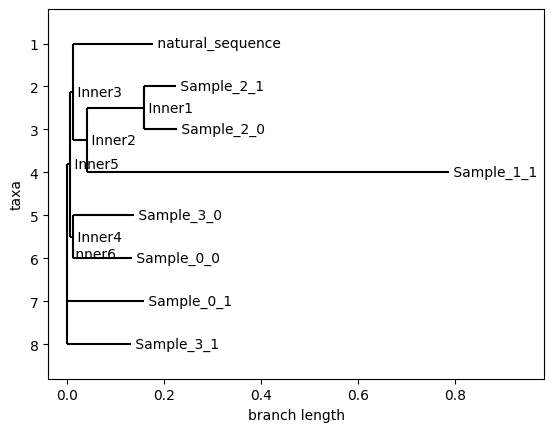

In [13]:
# Phylogenetic tree to check the relation between sequence
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio import Phylo

# Construct a phylogenetic tree using the NJ (Neighbor-Joining) algorithm
constructor = DistanceTreeConstructor()
tree = constructor.nj(dm)

# save tree file
Phylo.write(tree, "phylogenetic_tree.xml", "phyloxml")

# plot the tree
Phylo.draw(tree)


# 6.2 Enzyme-substrate Pairs prediction
## Enzyme-Substrate Pairing validation Workflow

## 1. Functional Prediction
- **Objective**: Predict the enzyme-substrate pair using a model. 
- **Tool/Method**: 
  - Perform enzyme-substrate prediction (**ESP**) to identify candidate enzymes.
  
---

**2. Specific Substrate Enzyme Screening**  
- **Goal**: To identify the generated ADH sequences capable of catalyzing **ethanol**.  
- **Steps**:  
  1. **Prediction Output**: Utilize the results from Step 1 (ESP predictions).  
  2. **Filtering**: Retain enzymes that match the target alcohol substrate (ethanol).  
     - Exclude enzymes that do **not** match the desired substrate- **ethanol**.  
  3. Apply the same validation criteria as outlined previously.  

---





In [14]:
## We need to generate an embedding representation for the substrate as well
## here we use a pre-trained model of the substrate ChemBERTa 
from transformers import AutoTokenizer, AutoModelForMaskedLM
import warnings

warnings.filterwarnings("ignore")

# Define the path to the pre-trained ChemBERTa model
SMILES_BERT = "/data/home/wuke/ChemBERTa-77M-MTR"

# Initialize an empty dictionary to store SMILES representations
smiles_reprs = {}

# Load the tokenizer for the pre-trained ChemBERTa model
smiles_tokenizer = AutoTokenizer.from_pretrained(SMILES_BERT)

# Load the pre-trained ChemBERTa model for masked language modeling
smiles_bert = AutoModelForMaskedLM.from_pretrained(SMILES_BERT)

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at /data/home/wuke/ChemBERTa-77M-MTR and are newly initialized: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
## Use pretrained-model(esm) to generate emb
import torch
import esm
# ESM accepts the protein sequence as input, generates an embedding vector for each position and outputs it.
def esm_method(sequence):
    # Determine the device to use (GPU if available, otherwise CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the pre-trained ESM model and its alphabet
    model, alphabet = esm.pretrained.load_model_and_alphabet('/data/home/jiahao/class2/esm2_t33_650M_UR50D.pt')
    model = model.to(device)  # Move the model to the specified device
    model.eval()  # Set the model to evaluation mode

    # Encode the input sequence into token IDs
    token_ids = torch.tensor([alphabet.encode(sequence)], device=device)

    # Forward pass through the model without gradient calculation
    with torch.no_grad():
        results = model(token_ids, repr_layers=[33])  # Get the output of the last layer (layer 33)
        token_embeddings = results["representations"][33]  # Extract the token embeddings from the results

    # Calculate the mean embedding for the entire sequence (optional)
    # token_embeddings = token_embeddings.mean(dim=1)
    
    return token_embeddings

In [16]:
# Input SMILES and generate embedding vectors of the input SMILES.
def smiles2vec1(smiles):
    """
    Function to get the last layer representation (logits) of a given SMILES string using the pre-trained ChemBERTa model.
    
    Args:
    - smiles (str): The SMILES string for which to obtain the representation.
    
    Returns:
    - last_layer_repr (torch.Tensor): The logits (last layer representation) of the SMILES string.
    """
    
    # Use the predefined tokenizer
    tokenizer = smiles_tokenizer
    
    # Use the predefined model
    model = smiles_bert
    
    # Freeze the model parameters to prevent backpropagation
    for param in model.parameters():
        param.requires_grad = False
    
    # Move the model to the CPU
    model = model.to('cpu')
    
    # Set the model to evaluation mode
    model.eval()
    
    # Define the key to extract the logits from the model output
    key = "logits"
    
    # Define the maximum length for tokenization
    max_length = 500
    
    # Tokenize the SMILES string
    tokens = tokenizer(
        smiles,
        max_length=max_length,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )
    
    # Get the last layer representation (logits) by passing the tokenized input through the model
    last_layer_repr = model(**tokens)[key]
    
    # Return the last layer representation
    return last_layer_repr

#### Here we choose ethanol as substrate to test if our protein can catalyze 

In [17]:
from Bio import SeqIO  # 
from tqdm import tqdm
# Generate embeddings for the sequences in fasta
print('----It may take about 2mins----')
input_fasta = "filtered_sequences_ec.fasta"
embeddings = []
# Iterate over each sequence in the fasta file
for record in SeqIO.parse(input_fasta, "fasta"):
    # Apply esm_method to the sequence
    embedding = esm_method(str(record.seq))
    embeddings.append(embedding)
substrate = 'CCO'
substrate_embedding = smiles2vec1(substrate)
print('-----Embeddings generated finish-----')
print('The embeddings of ethanol is:',substrate_embedding)

----It may take about 2mins----
-----Embeddings generated finish-----
The embeddings of ethanol is: tensor([[[-4.0516e-02,  0.0000e+00, -4.5512e-02,  ...,  5.8507e-01,
           2.4930e-01,  2.3387e-04],
         [ 4.7750e-01,  0.0000e+00, -7.5594e-02,  ...,  5.0739e-01,
           1.1898e-01,  1.3792e-01],
         [ 4.9148e-01,  0.0000e+00, -6.4201e-02,  ...,  4.7436e-01,
           1.4056e-01,  1.4429e-01],
         [ 4.1215e-01,  0.0000e+00, -1.8009e-02,  ...,  5.3705e-01,
           9.7094e-02,  1.8710e-01],
         [ 1.9668e-01,  0.0000e+00, -9.0332e-02,  ...,  6.5069e-01,
           1.9740e-01,  5.1417e-02]]])


In [18]:
## concat the embeddings of substrate and protein for the next step
concatenated_embedding = []
substrate_emb = substrate_embedding.mean(dim=1).cpu().detach().numpy()
for i in range(len(embeddings)):
    # Using average pooling to compress time/sequence dimensions.
    protein_emb = embeddings[i].mean(dim=1).cpu().detach().numpy()
    # concat the embeddings
    concatenated_embedding.append(np.concatenate([protein_emb, substrate_emb],axis=1))
print('-----Embeddings concat finish-----')

-----Embeddings concat finish-----


In [21]:
## Use a pretrained ESP model to predict
import xgboost as xgb
import random

model_path = '/data/home/wuke/xgboost_trained_model.json'
preds = []
for i in range(len(concatenated_embedding)):
    dtest = xgb.DMatrix(np.array(concatenated_embedding[i]))
    preds.append(get_prediction(dtest,model_path))
    print("Predictions:",f"sequence_id{i} can catalyze:", (preds[i]))

Predictions: sequence_id0 can catalyze: [0.6707349189157344]
Predictions: sequence_id1 can catalyze: [0.6301567501459531]
Predictions: sequence_id2 can catalyze: [0.6312209501492294]
Predictions: sequence_id3 can catalyze: [0.6993263338417165]
Predictions: sequence_id4 can catalyze: [0.6720064711011817]
Predictions: sequence_id5 can catalyze: [0.7288536938031953]
Predictions: sequence_id6 can catalyze: [0.7081951280617949]
Predictions: sequence_id7 can catalyze: [0.6365426723710126]


#### This output above represents the binding score between the sequence and the substrate, ranging from 0 to 1. We define scores greater than 0.5 as binding and scores less than 0.5 as non-binding.

### Filter out those enzymes which cannot catalyze ethanol.


In [22]:
from Bio import SeqIO

values = preds

input_fasta = "filtered_sequences_ec.fasta"  
output_fasta = "filtered_sequences_esp.fasta"  

# Save the filtered fasta to a new file
with open(output_fasta, 'w') as output_handle:
    for idx, record in enumerate(SeqIO.parse(input_fasta, "fasta")):
        if values[idx][0] > 0.5:
            SeqIO.write(record, output_handle, "fasta")

print(f"Filtered sequences saved to {output_fasta}")


Filtered sequences saved to filtered_sequences_esp.fasta


# 6.3 Enzyme-Substrate Activity Prediction
## Enzyme-Substrate Activity Prediction Workflow

## 1. Predict Enzyme Activity and Affinity
- **Objective**: Use a pre-trained model to predict enzyme activity and substrate affinity.
- **Tool/Method**: 
  - Utilize **UniKP** for predictions.
  - **No training required**: We do not train an extra model, instead of directly loading the model and perform predictions.

---

## 2. Filter Top Predictions
- **Goal**: Identify the best generated ADH towards ethanol.
- **Steps**:
  1. **Top k by Activity**: Select enzymes with the **highest activity** values.
  2. **Top k by Affinity (KM)**: Select enzymes with the **lowest KM** values (strongest substrate affinity).
  3. **Comparison**: Compare the selected candidates with known enzymes:
      - **kcat**: Catalytic activity.
      - **KM**: Substrate affinity.

---

## 3. Analysis and Insights
- Assess how the predicted enzymes (top candidates) perform relative to existing known enzymes.
- Determine if the new candidates demonstrate superior activity or affinity values.




In [23]:
from Bio import SeqIO  # 
from tqdm import tqdm
# Generate embeddings for the filter sequences in fasta
print('----It may take about 1min----')
input_fasta = "filtered_sequences_esp.fasta"
embeddings = []
# Iterate over each sequence in the fasta file
for record in SeqIO.parse(input_fasta, "fasta"):
    # Apply esm_method to the sequence
    embedding = esm_method(str(record.seq))
    embeddings.append(embedding)

----It may take about 1mins----


In [24]:
# Import necessary libraries
import torch
from utils import split  # Import the split function from the utils module
from build_vocab import WordVocab  # Import the WordVocab class from the build_vocab module
from pretrain_trfm import TrfmSeq2seq  # Import the TrfmSeq2seq class from the pretrain_trfm module

def smiles_to_vec2(Smiles):
    """
    Convert a list of SMILES strings to their corresponding vector representations using a pre-trained transformer model.
    
    Args:
    - Smiles (list of str): List of SMILES strings to be converted to vectors.
    
    Returns:
    - X (torch.Tensor): Tensor containing the vector representations of the SMILES strings.
    """
    # Define special token indices
    pad_index = 0  # Padding token index. When dealing with variable-length sequences, shorter sequences are filled to a specified maximum length in order that all sequences have the same length for batch processing. The fill mark here is used to occupy the space.
    unk_index = 1  # Unknown token index. This index is used instead when a tag that does not exist in the vocabulary is encountered.
    eos_index = 2  # End-of-sequence token index
    sos_index = 3  # Start-of-sequence token index
    mask_index = 4  # Mask token index

    # Load the vocabulary
    # Here, a predefined vocabulary is loaded from a pickle file. This vocabulary contains all the tags that may appear in the SMILES string and their corresponding indexes. The vocabulary is loaded so that each character in SMILES can later be converted to its index value in the vocabulary.
    vocab = WordVocab.load_vocab('/data/home/wuke/vocab.pkl')

    def get_inputs(sm):
        """
        Convert a single SMILES string to its input representation (ids and segment ids).
        
        Args:
        - sm (str): A SMILES string.
        
        Returns:
        - ids (list of int): List of token indices.
        - seg (list of int): List of segment indices.
        """
        seq_len = 220  # Maximum sequence length
        sm = sm.split()  # Split the SMILES string into tokens

        if len(sm) > 218:
            # If the SMILES string is too long, truncate it
            # print('SMILES is too long ({:d})'.format(len(sm)))
            sm = sm[:109] + sm[-109:]  # Truncate the middle part
        # Convert tokens to indices, using the unknown token index for out-of-vocabulary tokens
        ids = [vocab.stoi.get(token, unk_index) for token in sm]
        # Add start-of-sequence and end-of-sequence tokens
        ids = [sos_index] + ids + [eos_index]
        # Create segment indices (all 1s for this task)
        seg = [1] * len(ids)
        # Pad the sequences to the maximum sequence length
        padding = [pad_index] * (seq_len - len(ids))
        ids.extend(padding)  # Extend the ids with padding
        seg.extend(padding)  # Extend the segment ids with padding
        return ids, seg

    def get_array(smiles):
        """
        Convert a list of SMILES strings to their input representations (ids and segment ids).
        
        Args:
        - smiles (list of str): List of SMILES strings.
        
        Returns:
        - x_id (torch.Tensor): Tensor of token indices.
        - x_seg (torch.Tensor): Tensor of segment indices.
        """
        x_id, x_seg = [], []  # Initialize lists for ids and segment ids
        for sm in smiles:
            a, b = get_inputs(sm)  # Get ids and segment ids for each SMILES string
            x_id.append(a)  # Append ids to the list
            x_seg.append(b)  # Append segment ids to the list
        # Convert lists to tensors
        return torch.tensor(x_id), torch.tensor(x_seg)

    # Initialize the pre-trained transformer model
    trfm = TrfmSeq2seq(len(vocab), 256, len(vocab), 4)
    # Load the pre-trained model weights
    trfm.load_state_dict(torch.load('/data/home/wuke/trfm_12_23000.pkl'))
    # Set the model to evaluation mode
    trfm.eval()

    # Split the SMILES strings into tokens
    x_split = [split(sm) for sm in Smiles]
    # Get the input representations (ids and segment ids)
    xid, xseg = get_array(x_split)
    # Encode the SMILES strings using the transformer model
    X = trfm.encode(torch.t(xid))  # Transpose the input tensor for the model
    return X

# Example usage 
smiles_list = ['CCO']  # List of SMILES strings
smiles_emb = smiles_to_vec2(smiles_list)  # Convert SMILES to vector representations
print(f'Embedding of the {smiles_list} are:\n', smiles_emb)  # Print the resulting embeddings

Embedding of the ['CCO'] are:
 [[ 0.00523071 -0.08264276  0.37686658 ...  1.0763633   0.436734
   0.85975695]]


In [25]:
## concat the embeddings of substrate and protein for the next step
device = torch.device('cpu')
smiles_emb_kcat = torch.tensor(smiles_emb)
concatenated_embedding = []
for i in range(len(embeddings)):
    # Using average pooling to compress time/sequence dimensions.
    pooled_protein_embedding = embeddings[i].mean(dim=1)  # [batch_size, feature_dim]
    pooled_substrate_embedding = substrate_embedding.mean(dim=1)  # [batch_size, feature_dim]
    # concat the embeddings
    concatenated_embedding.append(torch.cat((pooled_protein_embedding.to(device), smiles_emb_kcat.to(device)), dim=1))
print('-----Embeddings concat finish-----')

-----Embeddings concat finish-----


### Next we will predict Kcat and Km of the pair of Enzyme-substrate
### The reasonable ranges for Kcat and Km depend on the specific enzyme and substrate you are considering. You can look up the values on [BRENDA](https://www.brenda-enzymes.org/)

In [26]:
## Kcat prediction
from joblib import load
model = load('/data/home/wuke/smitrans_esm2_KCAT.joblib')

kcat_values = []
#   predict with pretrained model
def predict_kcat(model, Ifeature_new):
    """
    Predict Kcat values using the loaded model.
    
    """
    kcat_predictions = model.predict(Ifeature_new)
    return 10 ** kcat_predictions

for i in range(len(concatenated_embedding)):
    Ifeature_new = concatenated_embedding[i] 
    # predict
    kcat_predictions = predict_kcat(model, Ifeature_new)
    kcat_values.append(kcat_predictions)
    # result
    print(f"Predicted Kcat values for sequence_id {i} towards ethanol: {kcat_predictions} 1/s") # 子奕 这边你得问一下吴柯单位 然后把单位加上...如果是log10 你还得把他们转换成1/s 或者是1/h


Predicted Kcat values for sequence_id 0 towards ethanol: [2.41282954] 1/s
Predicted Kcat values for sequence_id 1 towards ethanol: [2.0648791] 1/s
Predicted Kcat values for sequence_id 2 towards ethanol: [3.34792862] 1/s
Predicted Kcat values for sequence_id 3 towards ethanol: [2.56582226] 1/s
Predicted Kcat values for sequence_id 4 towards ethanol: [2.64003453] 1/s
Predicted Kcat values for sequence_id 5 towards ethanol: [3.65398099] 1/s
Predicted Kcat values for sequence_id 6 towards ethanol: [2.96357974] 1/s
Predicted Kcat values for sequence_id 7 towards ethanol: [2.80091364] 1/s


In [27]:
## Km predition
from joblib import load
model = load('/data/home/wuke/smitrans_esm2_KM.joblib')

km_values = []
#   predict with pretrained model
def predict_km(model, Ifeature_new):
    """
    Predict Kcat values using the loaded model.
    
    """
    km_predictions = model.predict(Ifeature_new)
    return 10 ** km_predictions

for i in range(len(concatenated_embedding)):
    Ifeature_new = concatenated_embedding[i] 
    # predict
    km_predictions = predict_kcat(model, Ifeature_new)
    km_values.append(km_predictions)
    # result
    print(f"Predicted Km values for sequence_id {i} towards ethanol: {km_predictions} mM") 


Predicted Km values for sequence_id 0 towards ethanol: [0.075819] mM/s
Predicted Km values for sequence_id 1 towards ethanol: [0.12395808] mM/s
Predicted Km values for sequence_id 2 towards ethanol: [0.09150862] mM/s
Predicted Km values for sequence_id 3 towards ethanol: [0.12030109] mM/s
Predicted Km values for sequence_id 4 towards ethanol: [0.11514809] mM/s
Predicted Km values for sequence_id 5 towards ethanol: [0.11951452] mM/s
Predicted Km values for sequence_id 6 towards ethanol: [0.09762389] mM/s
Predicted Km values for sequence_id 7 towards ethanol: [0.10976456] mM/s


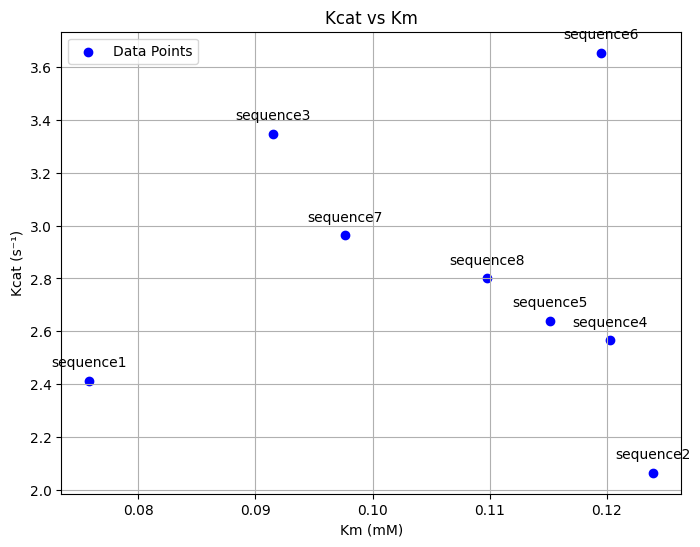

In [28]:
## Visualize the results with Km on the x-axis and Kcat on the y-axis
import matplotlib.pyplot as plt
# scatter-plot
plt.figure(figsize=(8, 6))  
plt.scatter(km_values,kcat_values, color='b', marker='o', label='Data Points')
plt.title('Kcat vs Km')
plt.xlabel('Km (mM)')
plt.ylabel('Kcat (s⁻¹)')
plt.grid(True)
plt.legend()
sequence_ids = ['sequence' + str(i+1) for i in range(len(km_values))]
for i, (km, kcat, seq_id) in enumerate(zip(km_values, kcat_values, sequence_ids)):
    plt.annotate(seq_id, (km, kcat), textcoords="offset points", xytext=(0,10), ha='center')
plt.show()


### Question 4: Which sequence has the highest Kcat or Km value for ethanol?


_____________________________________________________________________________

### Question 5: Summary of the result. Could you fulfill the table below? expand the rows if needed

| **sequence_id** | **sequence** | **predicted EC number** | **predicted substrates** | **kcat values with ethanol** | **KM values with ethanol** |  
|------------------|--------------|--------------------------|---------------------------|------------------------------|----------------------------|  
| seq_001          | AGCTGATCGA   | 1.1.1.1                 | ethanol                  | 5.6                          | 0.12                      |  
| seq_002          | TCGATGCTAG   | 1.1.1.2/1.1.1.65        | methanol, ethanol        | 3.2                          | 0.15                      |  
| seq_003          | GCTAGCTAGC   | 1.1.1.1                 | methanol                 | N/A                          | N/A                       |  
| seq_004          | CGTAGCTAGT   | 1.1.1.3                 | N/A                      | N/A                          | N/A                       |  

This table format is flexible for your dataset. You can replace the sample data with actual values from your results. 

### Question6 : Compare the Kcat and Km results with the ethanol data in [BRENDA](https://www.brenda-enzymes.org/) to evaluate how the generated sequences perform compared with the experimental results.

# 6.4 Molecular Docking
# Molecular Docking Workflow

## Structural Prediction and Molecular Docking
### Objective:
Predict the 3D structure of the target enzyme sequence and perform molecular docking with a specific substrate.

### Tools/Methods:
- **3D Structure Prediction**: Use **AlphaFold2** to predict the enzyme's three-dimensional structure.
- **Molecular Docking**:
  - Dock the predicted enzyme structure with the specific substrate.
  - Tools: **AutoDock Vina**

----
### Docking is a computational method used to predict the binding modes and interaction strengths between proteins and small molecules (ligands).It is an important tool in drug design, bioactivity research, and molecular recognition.
### Click [Docking](https://en.wikipedia.org/wiki/Docking_(molecular)) for more details



# Attetion
#### Choose one of your sequence to dock from your fasta
#### the following part need the pdb (protein database) format of your sequences
#### Please refer to exercise5 for detailed steps 
#### Relevant link:
#### [ColabFold](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb) -->PDB
#### [Alphafold3](https://alphafoldserver.com/)(Recommend) -->CIF

### Then we should convert our cif to pdb using the following function

In [23]:
## Transfer protein cif to pdb 

from Bio.PDB import MMCIFParser, PDBIO

def cif_to_pdb(input_cif, output_pdb):
    """
    Convert CIF file to PDB file using Biopython.
    Args:
        input_cif (str): Path to input CIF file.
        output_pdb (str): Path to output PDB file.
    """
    # Initialize parser and IO
    parser = MMCIFParser()
    structure = parser.get_structure("structure_id", input_cif)
    io = PDBIO()
    io.set_structure(structure)
    io.save(output_pdb)

input_cif = "input.cif"
output_pdb = "my.pdb"

# convert cif to pdb
cif_to_pdb(input_cif, output_pdb)
print(f"Conversion complete: {output_pdb}")


Conversion complete: my.pdb


### In order to avoid unnecessary package installations, we will perform molecular docking on the Colab version of [AutoDock Vina](https://colab.research.google.com/drive/1cHSl78lBPUc_J1IZxLgN4GwD_ADmohVU?usp=sharing). 

### **First we should upload our pdb to colab folder**
![image](Docking/0.png)

### Since we are using self-generated ADH enzymes, we need to make some modifications to Colab according to following steps.

1.
![image](Docking/1.1.png)

### 2.  Recepotor Preparation
replace the code by the next cell, be careful about the variable name

In [ ]:
# @title # 1.2 Receptor Preparation (< 30s)
%%time
#@markdown The preparation of a rigid receptor consists of two steps. The receptor structure is first sourced from a PDB file and sent to **reduce2.py** for hydrogen addition and optimization, and then, the conversion to a tangible receptor PDBQT file is done by **mk_prepare_receptor.py**.

#@markdown ## (1) Add Hydrogens to Receptor with Reduce2

# @markdown > Enter the PDB ID here to source the starting structure of receptor. This PDB file will be pulled from RCSB PDB server.
# Download PDB file
pdb_token = "my" #@param {type:"string"}
# ! curl "http://files.rcsb.org/view/{pdb_token}.pdb" -o "{pdb_token}.pdb"


# Export receptor atoms
atoms_from_pdb = parsePDB("my.pdb")
# @markdown > Use ProDy selection language to specify atoms to retain in receptor.
receptor_selection = "chain A and not water and not hetero" #@param {type:"string"}
receptor_atoms = atoms_from_pdb.select(receptor_selection)
prody_receptorPDB = f"{pdb_token}_receptor_atoms.pdb"
writePDB(prody_receptorPDB, receptor_atoms)


# Add CRYST1 card (temporarily required for reduce2)
reduce_inputPDB = f"{pdb_token}_receptor.pdb"
! cat <(grep "CRYST1" "{pdb_token}.pdb") {prody_receptorPDB} > {reduce_inputPDB}


# Run reduce2
# @markdown > Use PHIL arguments to specify the tasks for reduce2. In this example, we use `approach=add add_flip_movers=True` which is equivalent to `-build` or `-flip` in the formerly standalone reduce. These arguments ask ***reduce*** to allow NQH flips and build histidines to neutral tautomers while adding hydrogens.
reduce_opts = "approach=add add_flip_movers=True" #@param {type:"string"}
! export MMTBX_CCP4_MONOMER_LIB="{geostd_path}"; python {reduce2} {reduce_inputPDB} {reduce_opts}
# Default name of reduce output...
prepare_inPDB = f"{pdb_token}_receptorFH.pdb"

#@markdown ---
#@markdown ## (2) Receptor Preparation with Meeko

# Specify Box
# Center at ligand
atoms_from_pdb = parsePDB("my.pdb")
#@markdown > Use ProDy selection language to specify (ligand, residue, or any) atoms for box center calculation. In this example, we choose the ligand and will use the geometric center of ligand as box center.
ligand_selection = "chain A and resname LEU" #@param {type:"string"}
ligand_atoms = atoms_from_pdb.select(ligand_selection)
center_x, center_y, center_z = calcCenter(ligand_atoms)


#@markdown > Export ligand's original position to a PDB file. This is totally optional, but we will do it for visualization.
prody_ligandPDB = "LIG.pdb" #@param {type:"string"}
writePDB(prody_ligandPDB, ligand_atoms)


# Size in each dimension
#@markdown > Enter the box size (Å) of box in each dimension
size_x = 20.0 #@param {type:"raw"}
size_y = 20.0 #@param {type:"raw"}
size_z = 20.0 #@param {type:"raw"}


# @markdown With the above specifications, atom selection will be made on the original PDB file in ***ProDy***. Then, a protonated structure is generated by **reduce2.py**.
# @markdown
# @markdown The PDB file is then fed to **mk_prepare_receptor.py** to generate the receptor PDBQT file.

# Prepare Receptor
# @markdown > A basename for the receptor PDBQT file is required.
prepare_output = "my_receptorFH" #@param {type:"string"}
! python {mk_prepare_receptor} -i {prepare_inPDB} -o {prepare_output} -p -v --box_center {center_x} {center_y} {center_z} --box_size {size_x} {size_y} {size_z} --allow_bad_res


# Visualization with py3Dmol
def Receptor3DView(receptorPDB = None, boxPDB = None, ligPDB = None):

    view = py3Dmol.view()
    view.setBackgroundColor('white')

    view.addModel(open(boxPDB, 'r').read(),'pdb')
    view.addStyle({'stick': {}})
    view.zoomTo()

    view.addModel(open(receptorPDB, 'r').read(),'pdb')
    view.addStyle({'cartoon': {'color':'spectrum', 'opacity': 0.5}})

    if ligPDB is not None:
      view.addModel(open(ligPDB, 'r').read(), 'pdb')
      view.addStyle({'hetflag': True}, {'stick': {}})

    return view

Receptor3DView(receptorPDB = prepare_inPDB, \
               boxPDB = prepare_output+'.box.pdb', \
               ligPDB = prody_ligandPDB).show()

### 3.
![image](Docking/2.png) 

### 4. 
![image](Docking/3.png) 

### Question7: Print the figure and result you have docking with colab

![result](Docking/Docking.png)


| mode | affinity (kcal/mol) | dist from best mode | rmsd l.b. | rmsd u.b. |
|------|---------------------|---------------------|-----------|-----------|
| 1    | -2.394              | 0                   | 0         | 0         |
| 2    | -2.296              | 7.153               | 7.376     | 7.376     |
| 3    | -2.138              | 7.856               | 8.071     | 8.071     |
| 4    | -2.041              | 16.65               | 16.93     | 16.93     |
| 5    | -1.942              | 4.655               | 4.795     | 4.795     |
| 6    | -1.867              | 5.572               | 5.572     | 5.572     |
| 7    | -1.845              | 8.91                | 9.231     | 9.231     |
| 8    | -1.746              | 5.363               | 5.363     | 5.363     |
| 9    | -1.715              | 9.267               | 9.368     | 9.368     |


### Question8（Option）: You can utilize the natural sequence for molecular docking to verify whether the docking parameters are properly configured.